<a href="https://colab.research.google.com/github/Tao4free/Reinforcement_Learning/blob/master/maze_optimal_path/maze_optimal_path_monte_carlo_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import random, math, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import animation, rc
from matplotlib.offsetbox import OffsetImage, AnnotationBbox 

from IPython.display import display
from google.colab import files

# Set for animation display
rc('animation', html='jshtml')

# Class for Maze
Used in Dynamic Programming

In [0]:
class Maze:
    LEFT = "←"
    RIGHT = "→"
    UP = "↑"
    DOWN = "↓"
    START = "S"
    GOAL = "G"

    S_START = (3, 0)
    S_GOAL = (5, 8)
    V_START = 1
    V_GOAL = 2
    V_WALL = 3

    FONTSIZE = 18

    REWARD = -1
    REWARD_GOAL = 50
    REWARD_NEXTGOAL = 25


    def __init__(self, width=9, height=6):
        self.image = plt.imread(
            "https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning" + 
            "/master/maze_optimal_path/icon/luzhuzhu.png")
        self.shape = (height, width)
        self.countDraw = 0

        self.mkMaze()
        self.initSAP()
        self.mkPlt()

        self.isLearn =False

    def initSAP(self):
        # Initialize states
        gridStates = list(np.ndindex(self.shape))
        self.states = list(np.ndindex(self.shape))
        [self.states.remove(wall) for wall in self.wall_indexlist]

        # Initialize actions
        self.actions = [(-1, 0), (1, 0), (0, 1), (0, -1)]
        self.actionSymbols = dict(zip(self.actions, [self.LEFT, self.RIGHT, self.UP, self.DOWN]))
        self.actionSymbolsRev = dict(zip([self.LEFT, self.RIGHT, self.UP, self.DOWN], self.actions))

        # Initialize policy and value function
        self.policy = {}
        self.value = {}
        for s in gridStates:
            self.value[s] = 0
        for s in self.states:
            canActionList = self.supposeAction(s)
            numAction = len(canActionList)
            _isGoal = self.isGoal(s)
            for alist in canActionList:
                a = alist[0]
                # With uniform random action
                self.policy[(s,a)] = 1/numAction if not _isGoal else 0

    def supposeAction(self, s):
        canActionList = []
        _isGoal = self.isGoal(s)
        for a in self.actions:
            reward = self.REWARD
            s_new = tuple(np.asarray(s) + np.asarray(a)[::-1])
            canAction = s_new in self.states
            canGoal = s_new == self.S_GOAL
            if canAction and canGoal: reward = self.REWARD_NEXTGOAL
            if _isGoal: reward = self.REWARD_GOAL; s_new = self.S_GOAL
            if canAction: canActionList.append([a, reward, s_new])
        return canActionList

    def chooseAction(self, s):
        canActionList = self.supposeAction(s)
        policy_max = max([value for key, value in self.policy.items() if key[0] == s])
        policyActionList = [alist
                     for alist in canActionList
                     if self.policy[(s, alist[0])] == policy_max]
        policyAction = random.choice(policyActionList)
        return policyAction


    def mkPlt(self):
        # Make a color map of fixed colors
        self.cmap = colors.ListedColormap(["white", "yellow", "grey"])
        bounds=[0.5, 1.5, 2.5, 9.5]
        self.norm = colors.BoundaryNorm(bounds, self.cmap.N)

        # Make new figure and subplot axes
        self.fig, self.axes = plt.subplots(1,2, figsize=(15, 5))
        plt.close()

    def mkMaze(self):
        self.maze = np.zeros(self.shape, dtype=int)

        # Mark location
        self.maze[self.S_START] = self.V_START
        self.maze[self.S_GOAL] = self.V_GOAL

        # Mark wall for maze
        self.maze[2:5,2] = self.V_WALL
        self.maze[1,5] = self.V_WALL
        self.maze[3:6,7] = self.V_WALL

        # Get wall index
        self.wall_index = np.where(self.maze == self.V_WALL)
        self.wall_indexlist = list(zip(self.wall_index[0], self.wall_index[1]))

    def isWall(self, s):
        if self.maze[s] == self.V_WALL:
            return True
        else:
            return False

    def isGoal(self, s):
        if self.maze[s] == self.V_GOAL:
            return True
        else:
            return False 

    def setImage(self, ax, loc):
        im = OffsetImage(self.image, zoom=0.072, resample=True)
        ab = AnnotationBbox(im, loc, xycoords='data', frameon=False, box_alignment=(0.5, 0.5)) 
        ab.set_zorder(1)
        ax.add_artist(ab)

    # Set maze layout for plot
    def setMaze(self, ax):
        argMark = dict(fontsize=self.FONTSIZE, ha="center", va="center")

        # Basic axes setting
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis("on")
        ax.spines["left"].set_linewidth(0.5)
        ax.spines["right"].set_linewidth(0.5)
        ax.spines["top"].set_linewidth(0.5)
        ax.spines["bottom"].set_linewidth(0.5)
        ax.spines["left"].set_color("k")
        ax.spines["right"].set_color("k")
        ax.spines["top"].set_color("k")
        ax.spines["bottom"].set_color("k")

        # Plot maze layout
        ax.pcolor(self.maze,snap="true", edgecolors="k", linewidths=0.5, cmap=self.cmap, norm=self.norm)

        # Add mark for start and goal and current location
        loc = (self.S_START[1] + 0.5, self.S_START[0] + 0.5)
        self.setImage(ax, loc)
        ax.text(self.S_START[1] + 0.5, self.S_START[0] + 0.5, self.START, **argMark)
        ax.text(self.S_GOAL[1] + 0.5, self.S_GOAL[0] + 0.5, self.GOAL, **argMark)

        # Prevent auto plot.show() in google colab
        plt.close()

    # Set the possible action according to policy
    def setAction(self, ax):
        actionColor = "deepskyblue"
        argActionLeft = dict(fontsize=self.FONTSIZE, ha="right", va="center", color=actionColor)
        argActionRight = dict(fontsize=self.FONTSIZE, ha="left", va="center", color=actionColor)
        argActionUp = dict(fontsize=self.FONTSIZE, ha="center", va="bottom", color=actionColor)
        argActionDown = dict(fontsize=self.FONTSIZE, ha="center", va="top", color=actionColor)
        argAction = dict(zip(self.actions, [argActionLeft, argActionRight, argActionUp, argActionDown]))

        # Add action directions for all cell
        for s in self.states:
            # if self.isWall(s): continue
            if self.isGoal(s): continue
            j = s[0] + 0.5
            i = s[1] + 0.5
            for a in self.actions:
                try:
                    policy = self.policy[(s, a)]
                except KeyError:
                    continue
                if policy <= 0: continue
                actionSymbol = self.actionSymbols[a]
                arg = argAction[a]
                ax.text(i, j, actionSymbol, **arg)
        plt.close()

    # Set the value of value function for heatmap
    def setValue(self, ax):
        value = np.zeros(self.shape)
        for s in self.value.keys():
            value[s] = self.value[s]

        # Plot heatmap
        pc = ax.pcolor(value, snap="true", edgecolors="w", linewidths=0.5)

        # Add value text for heatmap
        pc.update_scalarmappable()
        for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            red, green, blue = color[:3]*255
            brightness = (red*0.299 + green*0.587 + blue*0.114) > 180 #186
            color = "k" if brightness else  "w"
            ax.text(x, y, str(round(value, 2)), ha="center", va="center", color=color)
        plt.close()

    # Trigger to draw maze layout, policy and heatmap
    def draw(self):
        [ax.cla() for ax in self.axes]
        [ax.set_visible(True) for ax in self.axes] 
        self.countDraw += 1
        self.setMaze(self.axes[0])
        self.setAction(self.axes[0])
        self.setValue(self.axes[1]) 
        display(self.fig)

    # Get the steps that from start to goal of optimal policy
    def getNumActions(self):
        numActions = 0
        curState=self.S_START
        while True:
            numActions += 1
            nextState = self.chooseAction(curState)[-1]
            curState = nextState
            if curState == self.S_GOAL: return numActions

    # Animate the jerry"s actions in maze
    def animate(self):
        self.fig_ani, self.ax_ani = plt.subplots(1,figsize=(7.5, 5)) 
        self.setMaze(self.ax_ani)
        self.setAction(self.ax_ani)
        if self.isLearn:
            frames = self.getNumActions() + 1
        else:
            frames = 20
        framesSet = frames*5

        self.luzhuzhu = self.ax_ani.artists[0]

        # Reset luzhuzhu"s location
        def resetPos():
            curState = self.S_START
            curPos = tuple(np.add(curState, (0.5, 0.5))[::-1])
            self.luzhuzhu.xyann = curPos

        # Animate
        def setAnimate(i):
            curPos = self.luzhuzhu.xyann
            curState = tuple(np.subtract(curPos, (0.5, 0.5))[::-1])
            if i+1 % frames == 1: 
                resetPos()
                return self.ax_ani,
            else:
                curPos = self.luzhuzhu.xyann
                curState = tuple(np.subtract(curPos, (0.5, 0.5))[::-1])
                curState_int = tuple(int(x) for x in curState)
                nextState = self.chooseAction(curState_int)[-1]
                nextPos = tuple(np.add(nextState, (0.5, 0.5))[::-1])
                self.luzhuzhu.xyann = nextPos
                if curState == self.S_GOAL and nextState == self.S_GOAL:
                    resetPos()
                    return self.ax_ani,
                return self.ax_ani,

        # Call to aniamte
        self.anim = animation.FuncAnimation(self.fig_ani, setAnimate,
                                            frames=framesSet, interval=250, blit=False)
        
        # Option to write animation to mp4 and turn off rc('animation', html='jshtml')
        # writer = animation.writers["ffmpeg"](fps=3)
        # if self.isLearn:
        #     filename = "maze-optimal-path_dynamic-programming_demo_afterLearning.mp4"
        # else:
        #     filename = "maze-optimal-path_dynamic-programming_demo_beforeLearning.mp4"
        # self.anim.save(filename,writer=writer,dpi=300)
        # files.download(filename)

# Class for Maze mini
Used for verification and validation (sampling needs a lot computing resouce, so I need to deploy a simpler case)

In [0]:
class Maze_mini(Maze):
    LEFT = "←"
    RIGHT = "→"
    UP = "↑"
    DOWN = "↓"
    START = "S"
    GOAL = "G"

    S_START = (0, 0)
    S_GOAL = (2, 4)
    V_START = 1
    V_GOAL = 2
    V_WALL = 3

    FONTSIZE = 18

    REWARD = -1
    REWARD_GOAL = 50
    REWARD_NEXTGOAL = 25


    def __init__(self, width=5, height=3):
        self.image = plt.imread(
            "https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning" + 
            "/master/maze_optimal_path/icon/luzhuzhu.png")
        self.shape = (height, width)
        self.countDraw = 0

        self.mkMaze()
        self.initSAP()
        self.mkPlt()

        self.isLearn =False

    def setImage(self, ax, loc):
        im = OffsetImage(self.image, zoom=0.12, resample=True)
        ab = AnnotationBbox(im, loc, xycoords='data', frameon=False, box_alignment=(0.5, 0.5)) 
        ab.set_zorder(1)
        ax.add_artist(ab)

    def mkMaze(self):
        self.maze = np.zeros(self.shape, dtype=int)

        # Mark location
        self.maze[self.S_START] = self.V_START
        self.maze[self.S_GOAL] = self.V_GOAL

        # Mark wall for maze
        self.maze[0,1] = self.V_WALL
        # self.maze[2,1] = self.V_WALL
        self.maze[1,3] = self.V_WALL

        # Get wall index
        self.wall_index = np.where(self.maze == self.V_WALL)
        self.wall_indexlist = list(zip(self.wall_index[0], self.wall_index[1]))

# Materials
| Exploring Starts | On-policy ε-soft policies |
|---|---|
|<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Book_MonteCarlo_ES.png" width="600"/> | <img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Book_MonteCarlo_onpolicy-firstvisit-epsilonsoft.png" width="600"/>|

#Hints
- When you reverse the order of episode for loop, G<-gamma*G + R will work for below formula.
<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Book_G_sum.png" width="300"/>
<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Book_G_iteration.png" width="600"/>

-  When you update the policy after one episode or some episodes, you will encounter the dilemma which leads to infinite loop.
<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/MazeMini_MC_ES_dilemma.png" width="600"/>

# Class for Monte Carlo Methods



In [0]:
from multiprocessing import Process, Pool
class RL_mc:
    def __init__(self, maze):
        self.maze = maze
        # Make math.isclose gives "right" comparison result when according to heatmap
        self.mathclose = 9e-3
        self.stepTolerant = 500
        # pairs = [(s, alist[0]) for s in self.maze.states for alist in self.maze.supposeAction(s)]
        # print(pairs)

    def generateStart(self, es=False):
        s_start = random.choice(self.maze.states) if es else self.maze.S_START
        a_start, r_start, s_new = random.choice(self.maze.supposeAction(s_start))
        start = [s_start, a_start, r_start, s_new]
        # print("\nStart: {}, action: {}".format(s_start, self.maze.actionSymbols[a_start]))
        return start

    def es_generateEpisode(self, es=True):
        self.dilemma = False
        self.episode = []
        self.path = []
        start = self.generateStart(es)
        self.episode.extend(start)
        self.path.extend(start[::len(start)-1])
        numStep = 0
        while True:
            numStep += 1
            s_tail = self.episode[-1]
            if numStep > self.stepTolerant:
                self.dilemma = True
                break
            if s_tail == self.maze.S_GOAL: 
                self.episode.pop(); 
                it = iter(self.episode)
                self.episode = list(zip(it, it, it))
                break
            step = self.maze.chooseAction(s_tail)
            self.episode.extend(step)
            self.path.append(step[-1])

    def es_updateQ(self, firstVisit=True, reward_decline=1.0):
        # self.drawEpisode()
        self.episode.reverse()
        # print(self.episode)
        G = 0
        for idx, (s, a, r) in enumerate(self.episode):
            sa = (s, a)
            [x.update({sa: 0})
                for x in [self.counterSA, self.q] 
                if not sa in x.keys()]

            allVisit_idx = list(i for i, step in enumerate(self.episode) if step[0:2] == sa)
            firstVisit_idx = allVisit_idx[-1]
            if firstVisit: 
                if firstVisit_idx == idx and len(allVisit_idx) > 1: continue
            G = reward_decline*G + r
            self.counterSA[sa] += 1
            nsa = self.counterSA[sa]
            self.q[sa] = (nsa-1)*self.q[sa]/nsa + G/nsa
            """
            Update value function of state by average, 
            or use "self.maze.value[s] = qmax_value" to update
            """
            # ns = sum([value for key, value in self.counterSA.items() if key[0] == s])
            # self.maze.value[s] = (ns-1)*self.maze.value[s]/ns + G/ns

    def es_updatePolicy(self, firstVisit=True, reward_decline=1.0):
        stateList = list(dict.fromkeys([s for (s, a, r) in self.episode]))
        for s in stateList:
            ########################
            # self.drawEpisode(cur=s)
            ########################
            policy_old = {key: 0 for key, value in self.maze.policy.items() if key[0] == s}
            self.maze.policy.update(policy_old)

            ########################
            # print("reset state {}'s policy".format(s)); self.maze.draw()
            ########################
            q = {key: value for key, value in self.q.items() if key[0] == s}
            qmax_value = max(q.values(), default=0)
            qmax = {key: value 
                    for key, value in q.items() 
                    if math.isclose(value, qmax_value, abs_tol=self.mathclose)}
            policy_new = {key: 1/len(qmax) for key, value in qmax.items()}

            self.maze.value[s] = qmax_value
            self.maze.policy.update(policy_new)
            ########################
            # print("update state's {}'s policy".format(s)); self.maze.draw()
            ########################

    def es(self, numEpisode=1, reward_decline=1.0):
        self.counterSA = {}
        self.q = {}
        self.v = {}

        for i in range(numEpisode):
            sys.stdout.write('\rLoop: '+str(i+1))
            self.es_generateEpisode()
            # Skip the closed episode that can't reach the goal
            if self.dilemma: continue
            self.es_updateQ()
            self.es_updatePolicy()

    def drawEpisode(self, cur=(-1,-1)):
        showstep = cur != (-1,-1)
        argMark = dict(fontsize=self.maze.FONTSIZE, ha="center", va="center", color="r")
        verts = [(p[1] + 0.5, p[0] + 0.5) for p in self.path]
        xs, ys = zip(*verts)

        self.fig_epi, self.axes = plt.subplots(1, 2, figsize=(15, 5)) 
        self.ax_epi = self.axes[0]
        self.ax_value = self.axes[1]
        self.maze.setMaze(self.ax_epi)
        self.maze.setAction(self.ax_epi)
        self.maze.setValue(self.ax_value)
        self.ax_epi.plot(xs, ys, '--', color="purple") #"deepskyblue"

        if not showstep:
            self.ax_epi.text(verts[0][0], verts[0][1], "●", **argMark)
        else:
            self.ax_epi.text(cur[1] + 0.5, cur[0] + 0.5, "◆", **argMark)

        display(self.fig_epi)

# Trial of solving Maze
Found the computing sonsumes time when do V&V, so min model of Maze is needed for quick check.

## Exploring Start
You can make not bad approximate results from ES under finite episodes compared to Dynamic Progamming showed below [DP github url](https://github.com/Tao4free/Reinforcement_Learning/blob/master/maze_optimal_path/maze_optimal_path_dynamic_programming.ipynb):
<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Maze_DP.png" width="600"/>  
The bigger states space, the more episodes are needed to generate quite good approximation.

Initialize the maze


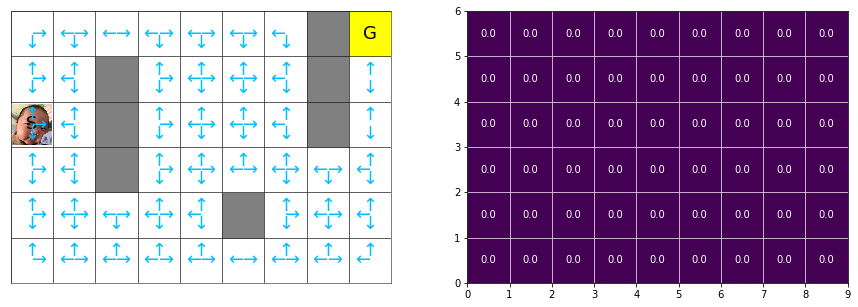

Learning
Loop: 20000

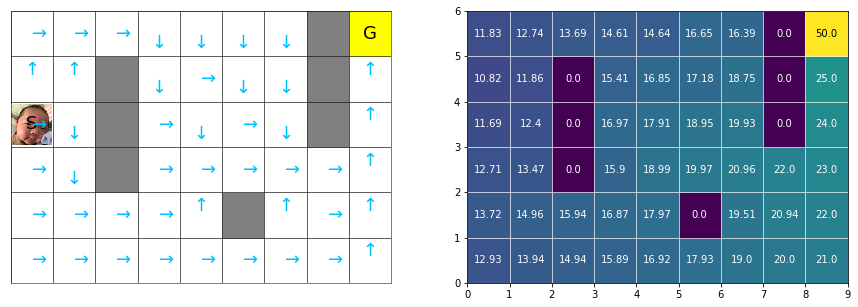

CPU times: user 1min 55s, sys: 1.2 s, total: 1min 56s
Wall time: 1min 56s


In [244]:
%%time

print("Initialize the maze")
maze = Maze()
maze.draw()

print("Learning")
rlmc = RL_mc(maze)
rlmc.es(numEpisode=20000)
maze.draw()

# Trial of solving Maze mini
Test the algorithmn with Maze_mini a simple model for maze

## Exploring Start
You can make quite good approximate results from ES compared to Dynamic Progamming showed below [DP github url](https://github.com/Tao4free/Reinforcement_Learning/blob/master/maze_optimal_path/maze_optimal_path_dynamic_programming.ipynb):
<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/MazeMini_DP.png" width="600"/>  
However, you need more computing resource, and you may get quite different results under the same number of episodes.

Initialize the maze


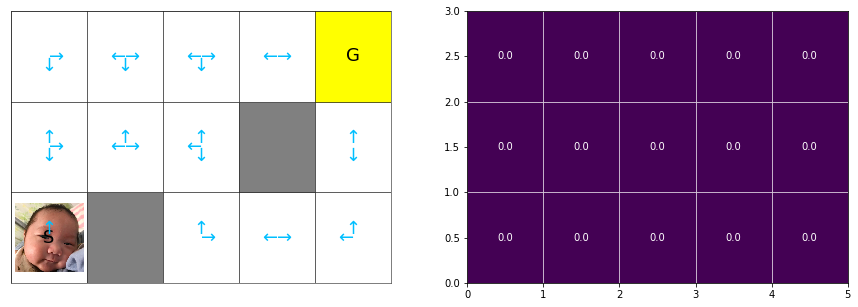

Learning
Loop: 20000

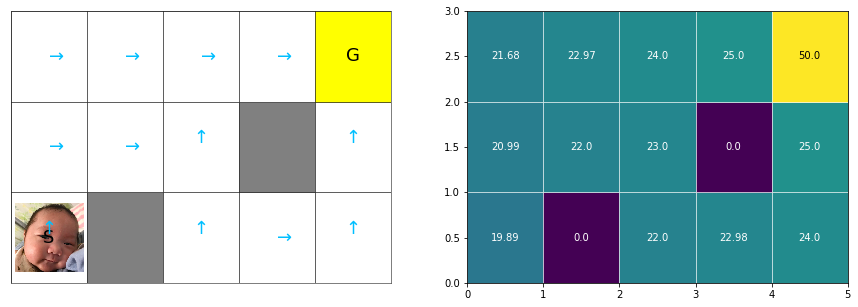

CPU times: user 10.4 s, sys: 668 ms, total: 11 s
Wall time: 10.5 s


In [238]:
%%time

print("Initialize the maze")
maze = Maze_mini()
maze.draw()

print("Learning")
rlmc = RL_mc(maze)
rlmc.es(numEpisode=20000)
maze.draw()